## 在耶拿数据上处理



# 大坑！recurrent_dropout==0才能cudnn加速

首先只用卷积层

In [1]:
import os

data_dir ='/home/wufisher/dataset_m/jena_climate'
fname= os.path.join(data_dir,'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))
import numpy as np


float_data = np.zeros((len(lines),len(header)-1))
for i,line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i,:]=values

mean= float_data[:200000].mean(axis=0)
float_data-=mean
std =  float_data[:200000].std(axis=0)
float_data/=std

def generator(data,lookback,delay,min_index,max_index,shuffle=False,batch_sice=128,step=6):
    if max_index is None:
        max_index = len(data)-delay-1
    i = min_index+lookback
    while 1 :
        if shuffle:
            rows = np.random.randint(
                min_index+lookback,max_index,size=batch_sice
            )
        else :
            if i+batch_sice>=max_index:
                i=min_index+lookback
            rows=np.arange(i,min(i+batch_sice,max_index))
            i+=len(rows)

        samples = np.zeros((len(rows),lookback//step,data.shape[-1]))
        targets = np.zeros((len(rows),))

        for j , row in enumerate(rows):
            indices = range(rows[j]-lookback,rows[j],step)
            samples[j]=data[indices]
            targets[j]=data[rows[j]+delay][1]
        yield samples , targets

lookback  = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
lookback=lookback,
delay=delay,
min_index=0,
max_index=200000,
shuffle=True,
step=step,
batch_sice=batch_size)

val_gen = generator(float_data,
lookback=lookback,
delay=delay,
min_index=200001,
max_index=300000,
step=step,
batch_sice=batch_size)

test_gen = generator(float_data,
lookback=lookback,
delay=delay,
min_index=300001,
max_index=None,
step=step,
batch_sice=batch_size)

# 得到验证和测试需要抽取多少次

val_steps = (300000-200001-lookback)//batch_size
test_steps = (len(float_data)-300001-lookback)//batch_size

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [2]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import rmsprop_v2

model= Sequential()
model.add(layers.Conv1D(32,5,activation='relu',input_shape=(None,float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32,5,activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32,5,activation='relu'))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(1))

model.compile(optimizer=rmsprop_v2.RMSprop(),loss='mae')
history = model.fit(
    train_gen,
    steps_per_epoch=500,
    epochs=20,
    validation_data=val_gen,
    validation_steps=val_steps
)

2021-12-22 20:20:36.595474: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-22 20:20:37.081131: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9118 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:65:00.0, compute capability: 7.5


Epoch 1/20


2021-12-22 20:20:38.276986: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


500/500 [==============================] - 16s 27ms/step - loss: 0.4087 - val_loss: 0.4511
Epoch 2/20
500/500 [==============================] - 14s 28ms/step - loss: 0.3564 - val_loss: 0.4639
Epoch 3/20
500/500 [==============================] - 13s 26ms/step - loss: 0.3337 - val_loss: 0.4612
Epoch 4/20
500/500 [==============================] - 14s 28ms/step - loss: 0.3178 - val_loss: 0.4428
Epoch 5/20
500/500 [==============================] - 15s 30ms/step - loss: 0.3077 - val_loss: 0.4662
Epoch 6/20
500/500 [==============================] - 14s 29ms/step - loss: 0.2980 - val_loss: 0.4492
Epoch 7/20
500/500 [==============================] - 14s 29ms/step - loss: 0.2904 - val_loss: 0.5099
Epoch 8/20
500/500 [==============================] - 13s 27ms/step - loss: 0.2839 - val_loss: 0.4593
Epoch 9/20
500/500 [==============================] - 13s 27ms/step - loss: 0.2802 - val_loss: 0.4599
Epoch 10/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2762 - val_los

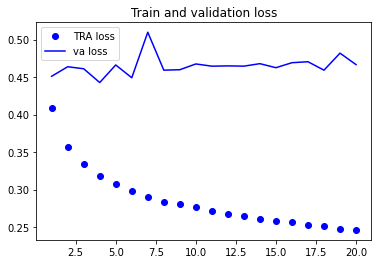

In [3]:
from matplotlib import pyplot as plt
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs = range(1,len(loss)+1)
plt.plot(epochs,loss,'bo',label='TRA loss')
plt.plot(epochs,val_loss,'b',label='va loss')
plt.title('Train and validation loss')
plt.legend()

plt.savefig('jena_conv1_v1_loss.png')
plt.show()

    使用卷积的时候由于并不能对数据点出现的时间（较早较晚对于预测的影响不同）产生变化
    但是卷积在对于时间序列非常长的时候可以将一维CNN提取为更短的CNN，在作为RNN序列输入进去，两者结合使用
    这里我们修改以下数据生成器，用更长的lookback或者更密集的step

In [9]:
lookback  = 720
# 这里修改step
step = 3
delay = 144
batch_size = 128

train_gen = generator(float_data,
lookback=lookback,
delay=delay,
min_index=0,
max_index=200000,
shuffle=True,
step=step,
batch_sice=batch_size)

val_gen = generator(float_data,
lookback=lookback,
delay=delay,
min_index=200001,
max_index=300000,
step=step,
batch_sice=batch_size)

test_gen = generator(float_data,
lookback=lookback,
delay=delay,
min_index=300001,
max_index=None,
step=step,
batch_sice=batch_size)

# 得到验证和测试需要抽取多少次

val_steps = (300000-200001-lookback)//batch_size
test_steps = (len(float_data)-300001-lookback)//batch_size

In [10]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import rmsprop_v2

model= Sequential()
model.add(layers.Conv1D(32,5,activation='relu',input_shape=(None,float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32,5,activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.GRU(32))
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer=rmsprop_v2.RMSprop(),loss='mae')
history = model.fit(
    train_gen,
    steps_per_epoch=500,
    epochs=20,
    validation_data=val_gen,
    validation_steps=val_steps
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, None, 32)          2272      
                                                                 
 max_pooling1d_6 (MaxPooling  (None, None, 32)         0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, None, 32)          5152      
                                                                 
 max_pooling1d_7 (MaxPooling  (None, None, 32)         0         
 1D)                                                             
                                                                 
 gru_2 (GRU)                 (None, 32)                6336      
                                                                 
 dense_3 (Dense)             (None, 1)                

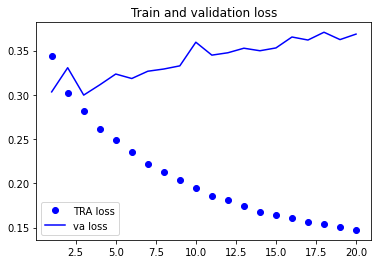

In [11]:
from matplotlib import pyplot as plt
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs = range(1,len(loss)+1)
plt.plot(epochs,loss,'bo',label='TRA loss')
plt.plot(epochs,val_loss,'b',label='va loss')
plt.title('Train and validation loss')
plt.legend()

plt.savefig('jena_conv1_v2_loss.png')
plt.show()

    效果虽然不如只用正则化，但是速度却快了很多    

In [13]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import rmsprop_v2

model= Sequential()
model.add(layers.Conv1D(32,5,activation='relu',input_shape=(None,float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32,5,activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.GRU(33,dropout=0.1))
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer=rmsprop_v2.RMSprop(),loss='mae')
history = model.fit(
    train_gen,
    steps_per_epoch=500,
    epochs=20,
    validation_data=val_gen,
    validation_steps=val_steps
)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, None, 32)          2272      
                                                                 
 max_pooling1d_8 (MaxPooling  (None, None, 32)         0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, None, 32)          5152      
                                                                 
 max_pooling1d_9 (MaxPooling  (None, None, 32)         0         
 1D)                                                             
                                                                 
 gru_3 (GRU)                 (None, 33)                6633      
                                                                 
 dense_4 (Dense)             (None, 1)                

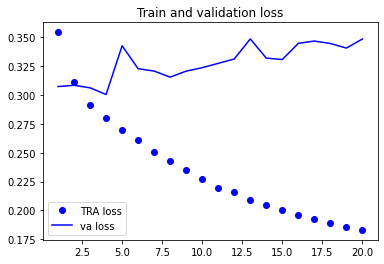

In [14]:
from matplotlib import pyplot as plt
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs = range(1,len(loss)+1)
plt.plot(epochs,loss,'bo',label='TRA loss')
plt.plot(epochs,val_loss,'b',label='va loss')
plt.title('Train and validation loss')
plt.legend()

plt.savefig('jena_conv1_dropout_v3_loss.png')
plt.show()